In [3]:
# import to read the csv files
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import statistics
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller



In [4]:
# reading the data from csv 
df  =  pd.read_csv('terraclimate.csv')
df.head()

,Year,Month,tmax,tmin,ppt
0,1958,1,5.89798,-6.31520,22.87821
1,1958,2,9.17997,-1.83897,42.90582
2,1958,3,7.13841,-5.19640,28.72127
3,1958,4,13.36199,-1.94881,26.05313
4,1958,5,23.89599,4.19911,14.07921


In [5]:
# creating matploit lib with python
# we shall create a a line graph to check the general trend of data,
#before we plot we follow this procedure
#1) combine year and month to be label for y axis

df['year_month'] =  df['Year'].astype(str) + " " + df['Month'].astype(str)
df['year_month']
# create column and indtroduce it
df.head()


,Year,Month,tmax,tmin,ppt,year_month
0,1958,1,5.89798,-6.31520,22.87821,1958 1
1,1958,2,9.17997,-1.83897,42.90582,1958 2
2,1958,3,7.13841,-5.19640,28.72127,1958 3
3,1958,4,13.36199,-1.94881,26.05313,1958 4
4,1958,5,23.89599,4.19911,14.07921,1958 5


In [6]:
# group panda for ploting because the data was too large
grouped_data = (df.groupby(['Year'], as_index=False).mean())
grouped_data.head()
            


,Year,Month,tmax,tmin,ppt
0,1958,6.5,18.297448,1.458483,22.733963
1,1959,6.5,18.520453,0.290372,11.048252
2,1960,6.5,17.833689,0.447406,18.937135
3,1961,6.5,17.918070,0.608028,18.152991
4,1962,6.5,17.194103,0.100198,19.642375


In [7]:
# set figure size to make the plots big
plt.rcParams["figure.figsize"] = [7, 6]



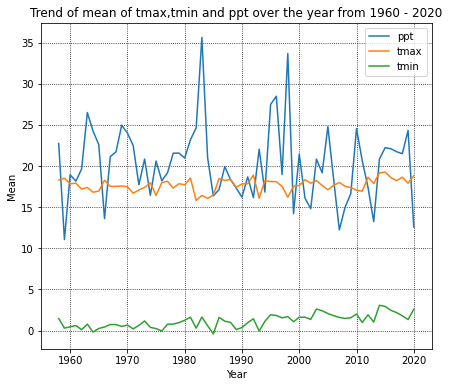

In [8]:
#plot the graph
plt.plot(grouped_data['Year'],grouped_data['ppt'],label="ppt")
plt.plot(grouped_data['Year'],grouped_data['tmax'],label="tmax")
plt.plot(grouped_data['Year'],grouped_data['tmin'],label="tmin")
plt.grid(True,color="k",linestyle=":")
plt.title("Trend of mean of tmax,tmin and ppt over the year from 1960 - 2020")
plt.xlabel("Year")
plt.ylabel("Mean")
plt.legend(loc=1);


In [9]:
#from the graph we see that the trend of the mean tempereture over the year tend to be linear,
#while that of the  precipitation (ppt) tend to also stagger over the mean of 20 over the year,
#also the temepreture max (tmax) also staggers over the mean of 20.


In [10]:
# from the data we can see that the data is stationary ,from the graph as both tend to have a constant mean a

In [11]:
# thus from that we know we can use arima model to model 
#our prediction since the data is a time series and the data is stationary (it has constant mean and variance)

In [12]:
# test for stationarity

def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)



In [13]:
ad_test(grouped_data['tmax'])

1. ADF :  -5.7246274797546
2. P-Value :  6.816170568624291e-07
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 62
5. Critical Values :
	 1% :  -3.540522678829176
	 5% :  -2.9094272025108254
	 10% :  -2.5923136524453696


In [14]:
# from this we see that the p value < 0.05 which shows that the 
# data is stationary

In [15]:
# we want to split the data into training and testing datase
#1) we check the number of rows in the data

len(df['tmax'])

756

In [16]:
all_dat = df.iloc[:,:3]
all_dat.head()

,Year,Month,tmax
0,1958,1,5.89798
1,1958,2,9.17997
2,1958,3,7.13841
3,1958,4,13.36199
4,1958,5,23.89599


In [17]:
all_dat['date'] = all_dat['Year'].astype(str)+"-"+all_dat['Month'].astype(str)+"-"+"1"
all_dat.head()

,Year,Month,tmax,date
0,1958,1,5.89798,1958-1-1
1,1958,2,9.17997,1958-2-1
2,1958,3,7.13841,1958-3-1
3,1958,4,13.36199,1958-4-1
4,1958,5,23.89599,1958-5-1


In [18]:
# split training data
all_data = all_dat.iloc[:,2:]
all_data['date'] = all_data['date'].astype('datetime64[ns]')
all_data.head()


,tmax,date
0,5.89798,1958-01-01
1,9.17997,1958-02-01
2,7.13841,1958-03-01
3,13.36199,1958-04-01
4,23.89599,1958-05-01


In [19]:
# check shape of training data
training_data = all_data.iloc[:500,]
training_data.head()

,tmax,date
0,5.89798,1958-01-01
1,9.17997,1958-02-01
2,7.13841,1958-03-01
3,13.36199,1958-04-01
4,23.89599,1958-05-01


In [20]:
testing_data = all_data.iloc[501:,:]
testing_data.head()

,tmax,date
501,21.84149,1999-10-01
502,14.03689,1999-11-01
503,7.14316,1999-12-01
504,6.82031,2000-01-01
505,8.14789,2000-02-01


In [21]:
# Check ACF and PACF plots to determine number of AR terms and 
# MA terms in ARMA model, or to spot seasonality/periodic trend
# Autoregressive forecast the next timestamp's value by
# regressing the previous values
# Moving Average forecast the next timestamp's value by
# averaging the previous values 
# Autoregressive Integrated Moving Average is useful 
# for non-stationary data, plus has an additional seasonal 
# differencing parameter for seasonal non-stationary data
# ACF and PACF plots include 95% Confidence Interval bands
# Anything outside of the CI shaded bands is a 
# statistically significant correlation 
# If we see a significant spike at lag x in the ACF 
# that helps determine the number of MA terms
# If we see a significant spike at lag x in the PACF 
# that helps us determine the number of AR terms


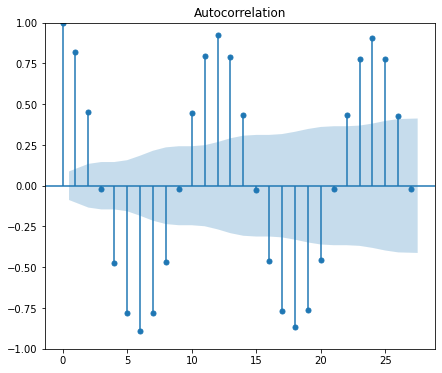

In [22]:
# we are using tempereture max for our prediction model
#acf graph
plot_acf(training_data['tmax'])
plt.show()


In [23]:
#from the graph above we can see a strong spike of data that means that there is a strong correlation 
#of the data to itself,also each year there is and increate in the middle strike over the years compared 
# to the end and the begining of the year this shows that an increase in tempereture which is a trend
# that we have seen in the past yr..that is jan is a little wormer then the tempereture rises between,
# may and june ,then it begins to decrease in the month of november,like in Nairobi example, there has
#been a decrese, in tempereture on november which was as a result of an impact in rainfall patterns,
#and even in decemer when the december started, this proves our point of stationarity
# of the data, and we can see a strong correlation from the data,which is good ,
#for our prediction model of arima to take effect


/home/lyrics/Desktop/projects/denno_machine/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


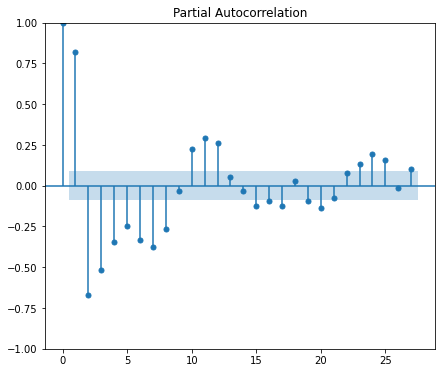

In [24]:

plot_pacf(training_data['tmax'])
plt.show()

In [25]:
# the acf and pacf are build on the concept of confidence intervals, that means,
#our shadded area on the graph is the confidence interval if the spike is too high off the graph,
# we see that that part of spike has a very high confidence interval.

In [26]:
# from the pacf we can see a significance at lag 2, which will be included to our ar order ,
# in the arima model

# there is also a significant spike for the acf model at lag 6,
#so we shall use the lag 6 for our ma term

In [27]:
# create a list of data , to prevent errors with arima summary
stepwise_fit = auto_arima(training_data['tmax'], trace=True,suppress_warnings=True)
stepwise_fit

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2429.499, Time=1.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3668.911, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3111.990, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3248.237, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4412.092, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2905.534, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2547.896, Time=0.68 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2546.377, Time=1.52 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2982.859, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2851.858, Time=1.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2518.338, Time=2.32 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2931.251, Time=0.27 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] interc

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [28]:
# Depending on ACF and PACF, create ARMA/ARIMA model 
# with AR and MA terms
# This will infer the frequency, so make sure there are 
# no gaps between datetimes
arima_model_tmax = ARIMA(np.array(training_data['tmax']), order=(2,0,2))
model = arima_model_tmax.fit()
model.summary()



/home/lyrics/Desktop/projects/denno_machine/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1197.281
Date:                Sun, 09 Jan 2022   AIC                           2406.561
Time:                        23:11:21   BIC                           2431.849
Sample:                             0   HQIC                          2416.484
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.5133      0.121    145.203      0.000      17.277      17.750
ar.L1          1.7320      0.000   1.53e+04      0.000       1.732       1.732
ar.L2         -1.0000   1.19e-05  -8.39e+04      0.000      -1.000      -1.000
ma.L1         -1.7307      0.577     -2.997      0.003      -2.862      -0.599
ma.L2          0.9998      0.668      1.496      0.135      -0.310       2.309
sigma2         6.8109      4.511      1.510      0.131      -2.031      15.653
===================================================================================
Ljung-Box (L1) (Q):                  36.06   Jarque-Bera (JB):                 4.72
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               1.18   Skew:                            -0.15
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# predition using model
start=len(training_data)
end=len(training_data)+len(testing_data)-1
pred=model.predict(start=start,end=end,typ='levels')



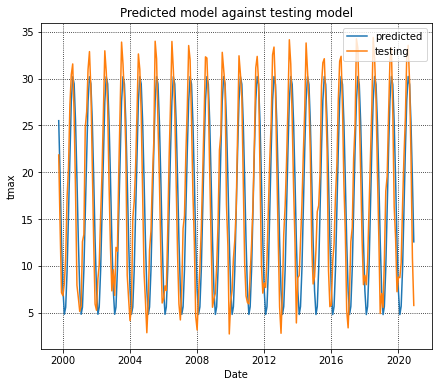

In [30]:
# plot the graph
plt.plot(testing_data['date'],list(pred),label="predicted")
plt.plot(testing_data['date'],testing_data['tmax'],label="testing")
plt.grid(True,color="k",linestyle=":")
plt.title("Predicted model against testing model")
plt.xlabel("Date")
plt.ylabel("tmax")
plt.legend(loc=1);

In [31]:
#predicting the future dataset,
# 1) check the tail of the dataset
all_dat.tail()

,Year,Month,tmax,date
751,2020,8,33.54410,2020-8-1
752,2020,9,29.49453,2020-9-1
753,2020,10,21.74019,2020-10-1
754,2020,11,10.84297,2020-11-1
755,2020,12,5.78121,2020-12-1


In [32]:
# refit the entire model with the arima model
arima_model_tmax = ARIMA(np.array(all_dat['tmax']), order=(2,0,2))
model2 = arima_model_tmax.fit()


/home/lyrics/Desktop/projects/denno_machine/env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
#future prediction
#1)getting date ranges
index_future_prediction = pd.date_range(start="2020-12-1",end="2022-01-30")
len(index_future_prediction)




426

In [43]:
pred2 = model2.predict(start=len(all_dat['tmax']),end=len(all_dat['tmax'])+ 425,typ='levels')

changed = pd.DataFrame(pred2, columns = ['Generated_tmax'])
changed.index = index_future_prediction
changed.tail(30)


,Generated_tmax
2022-01-01,4.786577
2022-01-02,5.720023
2022-01-03,9.864472
2022-01-04,16.109235
2022-01-05,22.780757
2022-01-06,28.091119
2022-01-07,30.617185
2022-01-08,29.681994
2022-01-09,25.536177
2022-01-10,19.290790
